In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from torchvision.utils import save_image, make_grid

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
path = '/content/drive/MyDrive/AutoEncoder_for_images/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


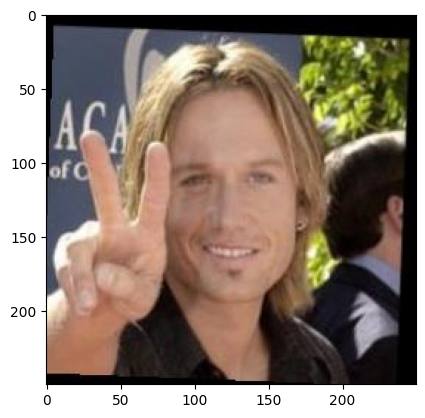

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

**Ans:** The dimensions of the sample image are 3X250x250.


1) The first dimension, 3, represents the number of color channels in the image.

2) The second dimension, 250, represents the height of the image in pixels.

3) The third dimension, 250, represents the width of the image in pixels.

In our case, the image has three color channels: red, green, and blue (RGB). Each channel has intensity values ranging from 0 to 255, with 0 indicating no color and 255 indicating full intensity of that color.

So, the image is a square of 250 pixels by 250 pixels, and each pixel has three color values (red, green, and blue) that determine its color.


In [8]:
# Get a batch of images and labels
images, labels = next(iter(dataloader))

# Get the first image from the batch of 32
sample_image = images[0]

# Print the dimensions of the sample image
print("Dimensions of the sample image:", sample_image.shape)

Dimensions of the sample image: torch.Size([3, 250, 250])


In [9]:
for x,y in dataloader:
    print(x[0].shape)
    print(x[0][0])
    print(x[0][0].shape)
    break

torch.Size([3, 250, 250])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0196, 0.0118, 0.0157,  ..., 0.0118, 0.0118, 0.0118],
        [0.0235, 0.0118, 0.0235,  ..., 0.0039, 0.0039, 0.0039],
        [0.0235, 0.0118, 0.0314,  ..., 0.0000, 0.0000, 0.0000]])
torch.Size([250, 250])


* x[0] is the 1st image out of 32 batch size and the dimension of that image is [3,250,250]
* Here, the range of the value for each pixel is [0,1] instead of [0,255] (the range for RGB values) because we have normalized the images.
* x[0][0] contains the 250 pixel values of red color for height and width. so its size will be[250,250] => values of red color for image 1.

# Step 3

Create a new pytorch model class for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [10]:
class AE(nn.Module):

    def __init__(self):
        super(AE,self).__init__()

        # Encoder
        self.encoded = self.encoder()

        # Decoder
        self.decoded = self.decoder()

    def encoder(self):
        return nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # output of the layer is 64, 250, 250
                                 nn.BatchNorm2d(64),  # output of the layer is 64, 250, 250
                                 nn.ReLU(True),  # output of the layer is 64, 250, 250
                                 nn.MaxPool2d(2, stride=2),  # output of the layer is 64, 125, 125
                                 nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # output of the layer is 128, 125, 125
                                 nn.BatchNorm2d(128),  # output of the layer is 128, 125, 125
                                 nn.ReLU(True),  # output of the layer is 128, 125, 125
                                 nn.MaxPool2d(2, stride=2),  # output of the layer is 128, 62,
                                 nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2),  # output of the layer is 128, 64, 64
                                 nn.BatchNorm2d(128),  # output of the layer is 128, 64, 64
                                 nn.ReLU(True),  # output of the layer is 128, 64, 64
                                 nn.MaxPool2d(2, stride=2) # output of the layer is 128, 32, 32
                                )

    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(64),

                             nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(64),

                             nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                             nn.Tanh()
                            )

    def forward(self, x):
        x = self.encoded(x)
        x = self.decoded(x)
        return x

# Hout =(Hin −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

In [11]:
# Create a sample input tensor to check the shape of output from decoder
model = AE()

# Create a sample input tensor with dimensions torch.Size([32, 3, 250, 250])
sample_input = torch.randn(32, 3, 250, 250)

# Pass the sample input through the model
output = model(sample_input)

# Print the shape of the output tensor
print(output.shape)  # Should be torch.Size([32, 3, 250, 250])

torch.Size([32, 3, 250, 250])


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [12]:
# Get a batch of images from the DataLoader
for images, _ in dataloader:

    # Check the shape of the output from the encoder and decoder

    output_of_encoder = model.encoded(images)
    print(output_of_encoder.shape)

    output_of_decoder = model.decoded(output_of_encoder)
    print(output_of_decoder.shape)

    forward_completed = model.forward(x)
    print(forward_completed.shape)

    break # Breaking the loop after processing the first batch


torch.Size([32, 128, 32, 32])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

**Total Number of Parameters:** The total number of parameters in a model can be calculated by iterating through the model's parameters (model.parameters()) and summing up the number of elements in each parameter tensor (p.numel()).

In [13]:
# Print the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 336579


**Loss Function:** Autoencoders tries to reduce the size of input data (x) into some samller latent space (z) by capturing the most important features of the data (X) and then try to reconstruct the original image from this latent space (Z) into new images (x_hat). (X -> Encoder -> Z -> Decoder -> X_hat)

For a good AE we want the genrated data to be as close to the original data and the latent space to be as small as possible. (Small latent space to make AE more efficient and less computational cost).

Hence, the MSE loss function is suitable as it tries to reduce the distance between generated data ad original data (In case of images, pixels values as close as possible).

I have taken MSE because autoencoders are trained to reconstruct their input data. The MSE measures the average squared difference between the input data and the reconstructed output. Minimizing the MSE encourages the model to produce reconstructions that are as close as possible to the original input data. Moreover, MSE penalizes larger errors more heavily due to squaring the differences between values.



In [14]:
# Loss function for reconstruction (MSE or similar)
criterion = nn.MSELoss()

**Optimizer:** The optimizer (such as Adam, SGD, or RMSprop) is responsible for updating the model's parameters during training to minimize the loss. I have used the Adam optimizer (torch.optim.Adam) and a learning rate of 0.001.

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [16]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')

def to_img(x):
    x = x.view(x.size(0), 3, 250, 250)
    return x

In [17]:
num_epochs = 150

for epoch in range(num_epochs):
    total_loss = 0
    for x,y in dataloader:

        # ===================forward=====================
        decoded_images = model.forward(x)
        loss = criterion(decoded_images, x)

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data
        break;
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))

    if epoch % 10 == 0:
        pic = to_img(decoded_images.cpu().data)
        save_image(pic, './generated/image_{}.png'.format(epoch))

epoch [1/150], loss:0.5811
epoch [2/150], loss:0.4319
epoch [3/150], loss:0.3069
epoch [4/150], loss:0.2728
epoch [5/150], loss:0.1717
epoch [6/150], loss:0.1861
epoch [7/150], loss:0.1819
epoch [8/150], loss:0.1554
epoch [9/150], loss:0.1449
epoch [10/150], loss:0.1245
epoch [11/150], loss:0.1319
epoch [12/150], loss:0.1297
epoch [13/150], loss:0.1118
epoch [14/150], loss:0.1212
epoch [15/150], loss:0.1265
epoch [16/150], loss:0.0977
epoch [17/150], loss:0.1129
epoch [18/150], loss:0.0769
epoch [19/150], loss:0.0869
epoch [20/150], loss:0.0906
epoch [21/150], loss:0.0915
epoch [22/150], loss:0.0785
epoch [23/150], loss:0.0925
epoch [24/150], loss:0.0898
epoch [25/150], loss:0.0863
epoch [26/150], loss:0.0707
epoch [27/150], loss:0.0802
epoch [28/150], loss:0.0779
epoch [29/150], loss:0.0592
epoch [30/150], loss:0.0763
epoch [31/150], loss:0.0651
epoch [32/150], loss:0.0745
epoch [33/150], loss:0.0564
epoch [34/150], loss:0.0509
epoch [35/150], loss:0.0477
epoch [36/150], loss:0.0695
e

In [23]:
torch.save(model.state_dict(), './generated/conv_autoencoder.pth')

In [24]:
model = AE()

In [25]:
filepath = './generated/conv_autoencoder.pth'
model.load_state_dict(torch.load(filepath))

<All keys matched successfully>

What to do if loss is not decreasing ?

I have tried Following things to optimize the loss.


**Learning Rate Adjustment:**

The learning rate might be too high, causing instability, or too low, slowing down the learning process. I tried adjusting the learning rate.

**Model Complexity:**

The model might be too simple or too complex for the dataset. I adjusted the model's architecture by adding/removing layers, changing the number of units, or altering the network structure. Simplify the model if it's overfitting or overly complex.

**Inspecting Individual Examples:**

Certain examples might be causing high loss due to anomalies or difficult-to-reconstruct samples.I tried to Analyze individual examples with high reconstruction loss. It might reveal patterns, anomalies, or data issues that the model struggles to learn.

**Experimentation and Debugging:**

There might be other issues specific to our dataset or model architecture.
I tried to experiment with different architectures, loss functions, optimizers, or hyperparameters.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

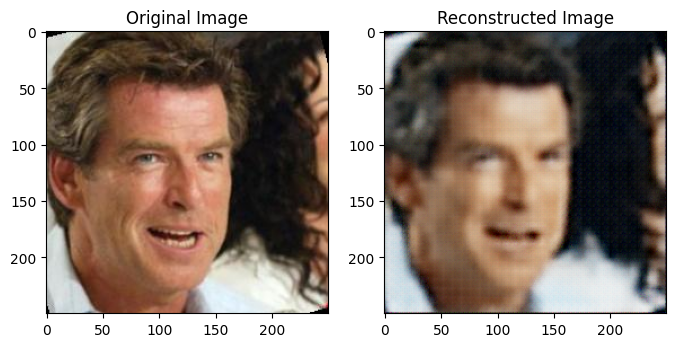

In [26]:
for images, _ in dataloader:
    original_image = images[21]

    # Forward pass through the model
    with torch.no_grad():
        reconstructed_image = model(original_image.unsqueeze(0))  # Add an extra dimension for batch size

    # Convert tensors to numpy arrays for visualization
    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_np)
    axes[1].set_title('Reconstructed Image')

    plt.show()

    break

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

**Adding normally distributed noise to the latent(hidden) representation.**


---




=> Adding noise to the latent (hidden) representation of an image in an autoencoder can have several effects on the decoded image.

=> Firstly, it can make the decoder more robust. By adding noise, the decoder is forced to learn to reconstruct the original image despite the presence of small perturbations in the latent representation. This can make the decoder less sensitive to small changes in the latent representation and can potentially improve the quality of the decoded image.

=> Secondly, adding noise can help to prevent overfitting. Overfitting occurs when a model learns to perfectly reproduce the training data but performs poorly on unseen data. By adding noise to the latent representation, the model is forced to learn more general features of the data, which can improve its performance on unseen data.

=> However, the effect of adding noise to the latent representation will depend on the specific characteristics of the noise and the data. If the noise is too large, it may overwhelm the signal in the latent representation and degrade the quality of the decoded image or going to make it more distorted. Conversely, if the noise is too small, it may not have a significant effect on the decoder's robustness or the model's ability to generalize.

tensor([[[[1.1243, 1.8341, 1.5765,  ..., 1.7748, 1.7140, 0.6571],
          [2.1622, 3.2724, 2.8261,  ..., 3.0365, 3.1256, 1.4521],
          [2.1245, 3.2388, 2.2909,  ..., 0.6704, 1.2482, 0.4277],
          ...,
          [3.1768, 4.5094, 4.5395,  ..., 3.1943, 3.9657, 1.4491],
          [2.4244, 3.6194, 3.8108,  ..., 3.2642, 3.8907, 1.4428],
          [1.2908, 1.8297, 1.8311,  ..., 2.1327, 2.3900, 0.8600]],

         [[1.2318, 2.7733, 2.7353,  ..., 2.8425, 2.7711, 2.0478],
          [1.2517, 3.1590, 3.0988,  ..., 2.9209, 3.0589, 2.5091],
          [1.2306, 3.1353, 3.1053,  ..., 0.0000, 0.0970, 0.2490],
          ...,
          [2.1400, 3.8670, 4.1529,  ..., 0.6384, 4.0180, 2.5824],
          [1.2885, 3.1890, 3.1696,  ..., 1.1754, 3.8429, 2.5698],
          [0.5518, 2.0089, 2.0061,  ..., 0.3886, 2.3784, 1.7405]],

         [[1.4661, 2.1129, 1.6976,  ..., 2.0510, 2.0583, 0.8676],
          [2.4586, 3.5433, 2.5904,  ..., 2.9021, 3.2172, 1.4898],
          [2.4189, 3.4211, 1.9653,  ..., 0

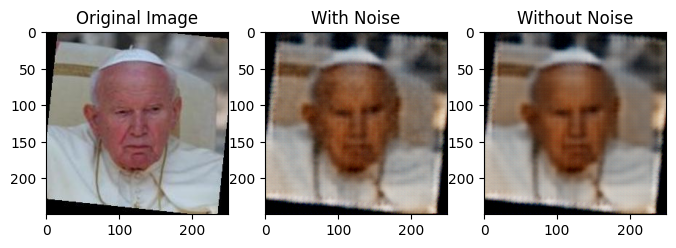

In [29]:
import torch.nn.functional as F

for images, _ in dataloader:
    original_image = images[20]

    latent_space_z = model.encoded(original_image.unsqueeze(0))

    print(latent_space_z)
    noise = torch.randn_like(latent_space_z) * 0.1
    print(noise)
    noisy_latent_space_z = latent_space_z + noise
    print(noisy_latent_space_z)

    reconstructed_image_noisy = model.decoded(noisy_latent_space_z)

    # Convert tensors to numpy arrays for visualization
    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_noisy_np = reconstructed_image_noisy.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed_image_without_noise_np = model.decoded(latent_space_z).squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_noisy_np)
    axes[1].set_title('With Noise')

    axes[2].imshow(reconstructed_image_without_noise_np)
    axes[2].set_title('Without Noise')


    break

# Show the plot outside the loop
plt.show()

=> The Reconstructed image is not getting better upon adding normally distributed noise.

=> Upon adding small noise the expectation is that the model should be able to handle the variation and generate better images.

=> This may happen if the latent space (z) is not a strong representation of the input image and adding noise make things worse.

=> If the latent space is robust then upon adding normally distributed noise the reconstructed image would get denoised and look more similar to the original image.

=> To make z robust, we need to train model with more layers or increase epoch or add linear layers.